In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def simulate_memristor(V, C, N, Vth=32.0, G_init=100.0, G_min = 0.0, G_max = 5000.0):
    G = np.zeros_like(V, dtype=float)
    I = np.zeros_like(V, dtype=float)

    G[0] = G_init
    I[0] = 0.0

    for k in range(1, len(V)):
        v1 = V[k-1]
        g1 = G[k-1]

        v2 = V[k]
        if v2 >= Vth:
            delta = C * (abs(v2) ** N)
            g2 = g1 + delta
        elif v2 <= -Vth:
            delta = C * (abs(v2) ** N)
            g2 = g1 - delta
        else:
            g2 = g1
        
        g2 = np.clip(g2, G_min, G_max)
        G[k] = g2

        dV = v2 - v1
        dG = g2 - g1
        I[k] = I[k-1] + dV * dG

    return G, I

In [22]:
V_points = np.array([-50, -25, 0, 25, 50, 25, 0, -25], dtype=float)

V = V_points

num_cases = 5 
results = []


for _ in range(num_cases):
    C_rand = np.random.uniform(0.01, 0.5)   
    N_rand = np.random.randint(1, 3)       
    G, I = simulate_memristor(V, C=C_rand, N=N_rand, Vth=32.0, G_init=100.0)
    results.append((C_rand, N_rand, G, I))

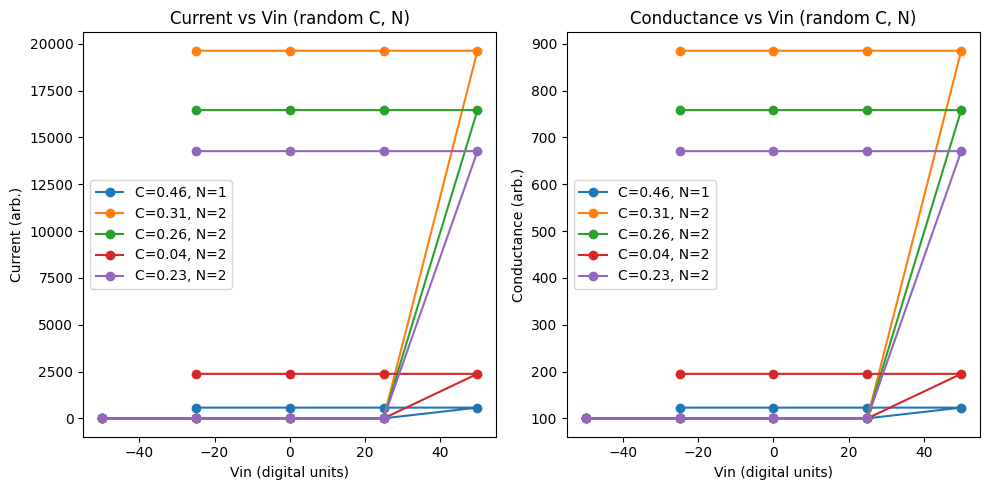

In [23]:
plt.figure(figsize=(10, 5))

# Current vs Vin
plt.subplot(1, 2, 1)
for C_rand, N_rand, G, I in results:
    label = f"C={C_rand:.2f}, N={N_rand}"
    plt.plot(V_points, I, marker='o', label=label)
plt.xlabel("Vin (digital units)")
plt.ylabel("Current (arb.)")
plt.title("Current vs Vin (random C, N)")
plt.legend()

# Conductance vs Vin
plt.subplot(1, 2, 2)
for C_rand, N_rand, G, I in results:
    label = f"C={C_rand:.2f}, N={N_rand}"
    plt.plot(V_points, G, marker='o', label=label)
plt.xlabel("Vin (digital units)")
plt.ylabel("Conductance (arb.)")
plt.title("Conductance vs Vin (random C, N)")
plt.legend()

plt.tight_layout()
plt.show()

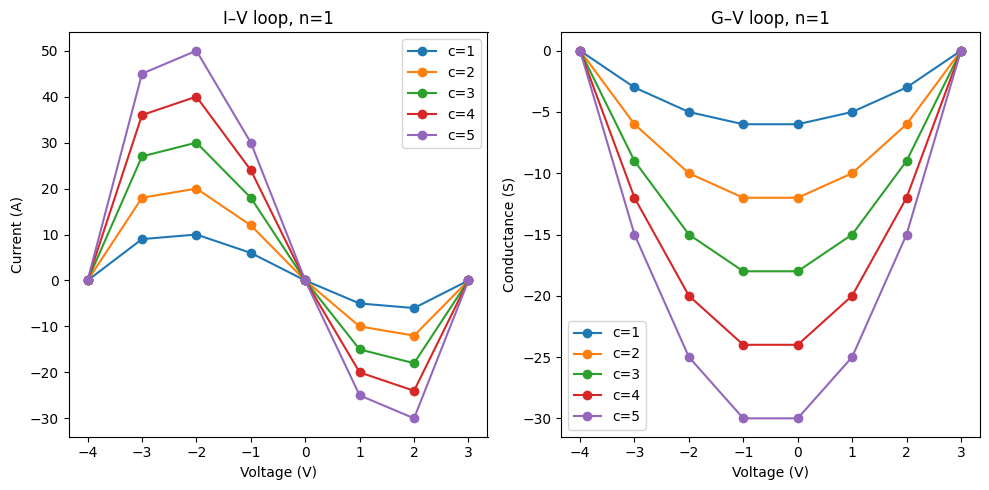

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def memristor_dc_sweep(V, c, n, Vth=1.0, G_init=0.0):
    """
    V: array of analog voltages in volts (e.g. -4..4)
    c, n: parameters from the paper
    Returns: G(V), I(V) arrays
    """
    G = np.zeros_like(V, dtype=float)
    I = np.zeros_like(V, dtype=float)
    G[0] = G_init

    for k in range(1, len(V)):
        v = V[k]
        g_prev = G[k-1]

        # thresholded update for conductance
        if v >= Vth:
            g_new = g_prev + c * (abs(v) ** n)
        elif v <= -Vth:
            g_new = g_prev - c * (abs(v) ** n)
        else:
            g_new = g_prev

        G[k] = g_new
        I[k] = g_new * v     # Ohm's law: I = G * V

    # also compute I,G at the first point
    I[0] = G[0] * V[0]
    return G, I

# 1) DC sweep from -4V to +4V as in the paper
V = np.array([-4, -3, -2, -1, 0, 1, 2, 3], dtype=float)

# 2) Choose fixed n for this panel, e.g. n = 4 (for Fig. 2(b),(f))
n = 1

# 3) Sweep c = 1..5
c_values = [1, 2, 3, 4, 5]

results = {}
for c in c_values:
    G, I = memristor_dc_sweep(V, c=c, n=n, Vth=1.0, G_init=0.0)
    results[c] = (G, I)

plt.figure(figsize=(10, 5))

# I-V hysteresis (like top row)
plt.subplot(1, 2, 1)
for c in c_values:
    G, I = results[c]
    plt.plot(V, I, marker='o', label=f"c={c}")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.title(f"I–V loop, n={n}")
plt.legend()

# G-V hysteresis (like bottom row)
plt.subplot(1, 2, 2)
for c in c_values:
    G, I = results[c]
    plt.plot(V, G, marker='o', label=f"c={c}")
plt.xlabel("Voltage (V)")
plt.ylabel("Conductance (S)")
plt.title(f"G–V loop, n={n}")
plt.legend()

plt.tight_layout()
plt.show()


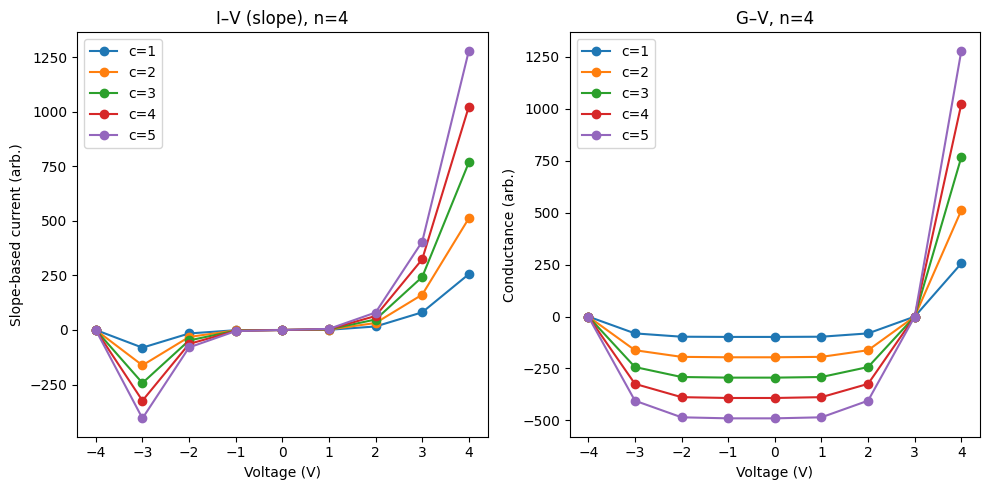

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def memristor_dc_sweep_slope(V, c, n, Vth=1.0, G_init=0.0):
    """
    V: array of voltages in volts (e.g. -4..4)
    c, n: memristor parameters
    Returns: G(V), I(V) where I is slope-based, not G*V
    """
    G = np.zeros_like(V, dtype=float)
    I = np.zeros_like(V, dtype=float)

    G[0] = G_init
    I[0] = 0.0

    for k in range(1, len(V)):
        v1 = float(V[k-1])
        g1 = float(G[k-1])

        v2 = float(V[k])

        # thresholded conductance update (same as before)
        if v2 >= Vth:
            g2 = g1 + c * (abs(v2) ** n)
        elif v2 <= -Vth:
            g2 = g1 - c * (abs(v2) ** n)
        else:
            g2 = g1

        G[k] = g2

        # slope-based current for this segment (local, not cumulative)
        dV = v2 - v1
        dG = g2 - g1
        I[k] = dV * dG   

    return G, I

# DC sweep from -4V to +4V as in the paper
V = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4], dtype=float)

# Choose n for this panel; change to 2, 4, 6 to mimic Fig. 2(a,b,c)/(d,e,f)
n = 4

# Sweep c = 1..5 (you can rescale c to match magnitudes)
c_values = [1, 2, 3, 4, 5]

results = {}
for c in c_values:
    G, I = memristor_dc_sweep_slope(V, c=c, n=n, Vth=1.0, G_init=0.0)
    results[c] = (G, I)

plt.figure(figsize=(10, 5))

# I–V plot with slope-based I
plt.subplot(1, 2, 1)
for c in c_values:
    G, I = results[c]
    plt.plot(V, I, marker='o', label=f"c={c}")
plt.xlabel("Voltage (V)")
plt.ylabel("Slope-based current (arb.)")
plt.title(f"I–V (slope), n={n}")
plt.legend()

# G–V plot is identical in shape to paper (only c varies)
plt.subplot(1, 2, 2)
for c in c_values:
    G, I = results[c]
    plt.plot(V, G, marker='o', label=f"c={c}")
plt.xlabel("Voltage (V)")
plt.ylabel("Conductance (arb.)")
plt.title(f"G–V, n={n}")
plt.legend()

plt.tight_layout()
plt.show()


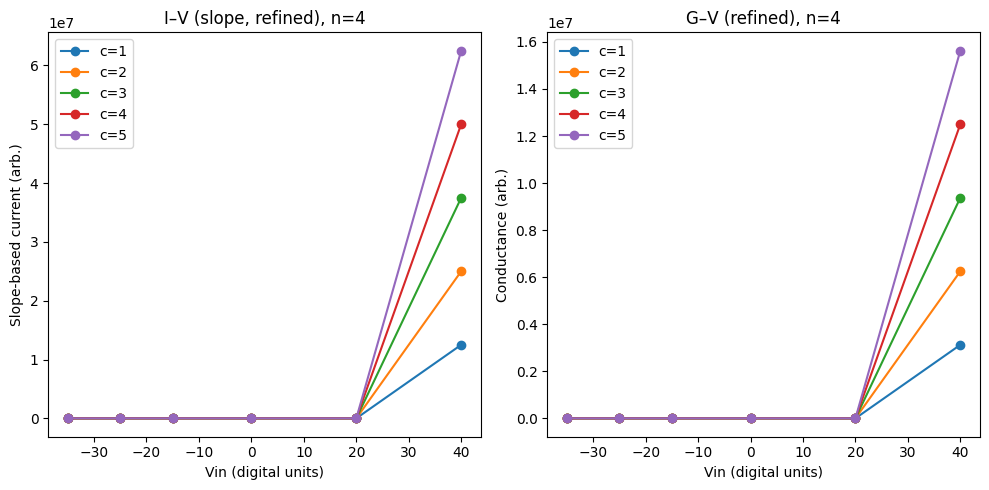

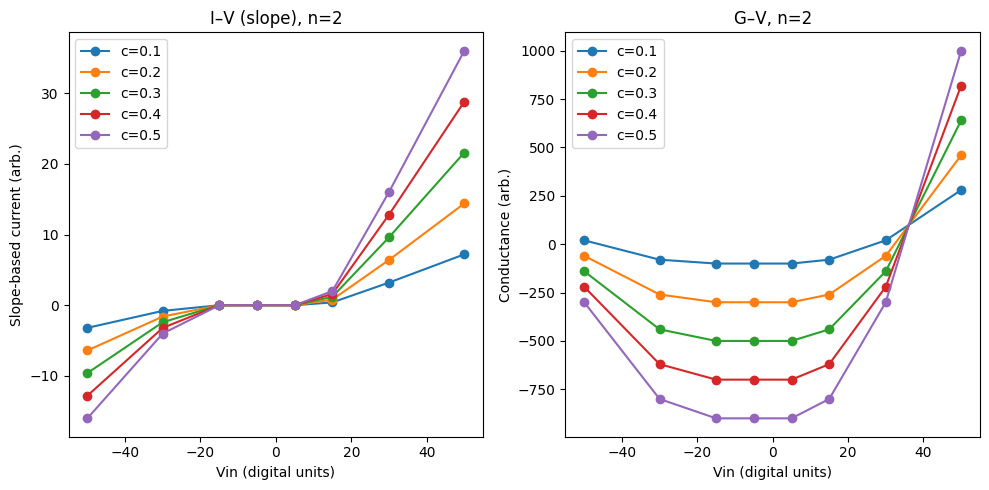

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def memristor_dc_sweep_slope(V, c, n, Vth=20.0, G_init=100.0, alpha=1.0):
    G = np.zeros_like(V, dtype=float)
    G[0] = G_init

    # conductance at each V
    for k in range(1, len(V)):
        v2 = float(V[k])
        g1 = float(G[k-1])

        if v2 >= Vth:
            g2 = g1 + c * (abs(v2) ** n)
        elif v2 <= -Vth:
            g2 = g1 - c * (abs(v2) ** n)
        else:
            g2 = g1

        G[k] = g2

    # segment midpoints and slope-based current
    Vm = 0.5 * (V[1:] + V[:-1])
    Gm = 0.5 * (G[1:] + G[:-1])
    dV = V[1:] - V[:-1]
    dG = G[1:] - G[:-1]
    Im = alpha * dV * dG

    return Vm, Gm, Im

# Revised Vin: symmetric, more points, still “digital units”
V = np.array([-60, -40, -20, -10, 0, 10, 20, 40, 60], dtype=float)

# Choose moderate exponent
n = 2

# Sweep c values
c_values = [0.1, 0.2, 0.3, 0.4, 0.5]

results = {}
for c in c_values:
    Vm, Gm, Im = memristor_dc_sweep_slope(V, c=c, n=n, Vth=20.0, G_init=100.0, alpha=1e-3)
    results[c] = (Vm, Gm, Im)

plt.figure(figsize=(10, 5))

# I–V (slope-based)
plt.subplot(1, 2, 1)
for c in c_values:
    Vm, Gm, Im = results[c]
    plt.plot(Vm, Im, marker='o', label=f"c={c}")
plt.xlabel("Vin (digital units)")
plt.ylabel("Slope-based current (arb.)")
plt.title(f"I–V (slope), n={n}")
plt.legend()

# G–V
plt.subplot(1, 2, 2)
for c in c_values:
    Vm, Gm, Im = results[c]
    plt.plot(Vm, Gm, marker='o', label=f"c={c}")
plt.xlabel("Vin (digital units)")
plt.ylabel("Conductance (arb.)")
plt.title(f"G–V, n={n}")
plt.legend()

plt.tight_layout()
plt.show()
